In [122]:
from importlib.resources import path
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [123]:
bevölkerung = pd.read_excel(f"Data\\12411-0012_complete.xlsx", index_col=0)

#read sterbefälle pro monat
sterbefälle_woche = pd.read_excel(f"Data\\sonderauswertung-sterbefaelle_groß.xlsx", sheet_name='D_2016_2022_KW_AG_Ins') #Datensatz ist selbst zusammengebaut
sterbefälle_woche = sterbefälle_woche[sterbefälle_woche.columns].replace(["-",".","X "],0)


In [124]:
#Sterbefälle einteilen
#bildet summe aus gruppe 90-95 und gruppe ü 95, ersetzt die 90-95 row damit, benennt sie um und dropt die ü95 reihe.
new_row = (sterbefälle_woche.loc[sterbefälle_woche["Alter"]=="90-95"]) + (sterbefälle_woche.loc[sterbefälle_woche["Alter"]=="95 u. mehr"])
_90_95 = sterbefälle_woche.loc[sterbefälle_woche["Alter"]=="90-95"]
mehr_95 = sterbefälle_woche.loc[sterbefälle_woche["Alter"]=="95 u. mehr"]

new_row = _90_95.iloc[0,3:] + mehr_95.iloc[0,3:]
index_95 = list(_90_95.index)
index_mehr = list(mehr_95.index)

for i in range (len(index_95)):
    new_row = _90_95.iloc[i,3:] +mehr_95.iloc[i,3:]
    sterbefälle_woche.loc[index_95[i], 1:] = new_row
    sterbefälle_woche.drop(index_mehr[i], inplace=True)
    
sterbefälle_woche['Alter'].replace({'90-95': '90<'}, inplace = True)



C:\Users\mikes\OneDrive\Desktop\Uni\PMDS\Code\venv\lib\site-packages\pandas\core\indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
C:\Users\mikes\OneDrive\Desktop\Uni\PMDS\Code\venv\lib\site-packages\pandas\core\indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
C:\Users\mikes\OneDrive\Desktop\Uni\PMDS\Code\venv\lib\site-packages\pandas\core\indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
C:\Users\mikes\OneDrive\Desktop\Uni\PMDS\Code\venv\lib\site-packages\pandas\core\indexing.py:2108: FutureWarning: In a future version, the Index constructor will not infer numeri

In [125]:
#alle Altersgruppen einteilen
rows = []
x = 0
j = 0
for k in range (1 ,32): 
    x=0
    for i in range(0, 92):
        k2 = k*91
        if i == 0 and k == 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[0]]["Gesamt"] #Gesamtbevölkerung je altersgruppe
        if i == 0 and k != 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+(k-1)*92]]["Gesamt"]
        else:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+((k-1)*92)]]["Gesamt"]

        if ( i < 30):
            x += bevölkerungs_anzahl
            if (i == 29):
                rows.append([1990+k-1,"0 - "+"<{}".format(i+1), x])
                x = 0   

        elif (i >= 30 and  i < 90):
            j += 1
            x += bevölkerungs_anzahl
            if j == 5:
                rows.append([1990+k-1,(str(i-4)+" - <"+str(i+1)), x])
                j = 0
                x = 0

        elif i == 90:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"90=<", x])
            x = 0

        elif i == 91:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"Gesamt", x])
            x=0
       
        

new_df = pd.DataFrame(rows, columns=["Jahr","Alter", "Anzahl"])




In [126]:

# bevölkerung_16 = new_df.loc[new_df["Jahr"]==2016]

# standard_bevölkerung.loc[standard_bevölkerung.index[14]][2]


# #print(bevölkerung_19)


# bevölkerung_16.loc[bevölkerung_16.index[14]][2]
# x = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2020)]
# y = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2019)]
# z = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2016)]

In [127]:
standard_bevölkerung = new_df.loc[new_df["Jahr"]==2020]

In [128]:
sterberaten_roh = []
sterberaten_bereinigt = []

In [129]:
#rohe sterberate
#loop über jahre
for n in range(0,21):
    z = sterbefälle_woche.loc[(sterbefälle_woche["Jahr"]==2020-n)]
    sterberate_woche = 0
    sterberate_jahr = 0
    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[14]][2]

    #loop über wochen
    for j in range (1, 54):
        sum = 0
        #loop über altersgruppen
        for i in range(0,14):
            mri = ((z.loc[z.index[i+1]][j]) / gesamt_bev) * 100000  #sterberate je altersgruppe
            sterberate_woche += mri 
    
        sterberate_jahr += sterberate_woche
        sterberate_woche = 0
    #print(2020-n, "Roh:", sterberate_jahr)
    sterberaten_roh.append([2020-n, sterberate_jahr])

In [130]:
#altersbereinigt
#loop über jahre
for n in range(0,21):
    z = sterbefälle_woche.loc[(sterbefälle_woche["Jahr"]==2020-n)]
    q = new_df.loc[new_df["Jahr"]==2020-n]
    erg_sum = 0
    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[14]][2]

    #loop über wochen
    for j in range (1, 54):
        sum = 0
        #loop über Altersgruppen
        for i in range(0,14):

            asx = standard_bevölkerung.loc[standard_bevölkerung.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
            bevölkerung_grp = q.loc[q.index[i]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
            subx = ((z.loc[z.index[i+1]][j]) / bevölkerung_grp) * 100000 #sterberate je altersgruppe
            
            sum += (asx * subx)    
            

        erg = sum / gesamt_bev
        erg_sum += erg

    #print(2020-n, "Altersbereinigt:",erg_sum)
    sterberaten_bereinigt.append([2020-n, erg_sum])

In [131]:
sterberaten_roh = pd.DataFrame(sterberaten_roh, columns=["Jahr", "Sterberate"])
sterberaten_bereinigt = pd.DataFrame(sterberaten_bereinigt, columns=["Jahr", "Sterberate"])
#print(sterberaten_bereinigt)
#print(sterberaten_roh)

In [132]:
#altersbereinigt
#wochenweise
#counter = 1096
sterberaten_bereinigt_woche = []
for n in range(0,21):
    z = sterbefälle_woche.loc[(sterbefälle_woche["Jahr"]==2020-n)]
    q = new_df.loc[new_df["Jahr"]==2020-n]
    erg_sum = 0
    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[14]][2]

    #loop über wochen
    for j in range (1, 54):
        sum = 0
        #loop über Altersgruppen
        for i in range(0,14):

            asx = standard_bevölkerung.loc[standard_bevölkerung.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
            bevölkerung_grp = q.loc[q.index[i]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
            subx = ((z.loc[z.index[i+1]][j]) / bevölkerung_grp) * 100000 #sterberate je altersgruppe
            
            sum += (asx * subx)    
        #counter -=1
   
        erg = sum / gesamt_bev
        

    #print(2020-n, "Altersbereinigt:",erg_sum)
     
              
        #sterberaten_bereinigt_woche.append([(2020-n),j, erg])
        if erg != 0:
            sterberaten_bereinigt_woche.append([(2020-n),j, erg])



In [133]:
#sterberaten_roh = pd.DataFrame(sterberaten_roh, columns=["Jahr", "Sterberate"])
sterberaten_bereinigt_woche = pd.DataFrame(sterberaten_bereinigt_woche, columns=["Jahr","Woche", "Sterberate"])
sterberaten_bereinigt_woche

#print(sterberaten_bereinigt)
#print(sterberaten_roh)

,Jahr,Woche,Sterberate
0,2020,1,22.708187
1,2020,2,23.339538
2,2020,3,22.792367
3,2020,4,22.640843
4,2020,5,23.779680
...,...,...,...
1091,2000,48,27.453311
1092,2000,49,27.475356
1093,2000,50,27.863052
1094,2000,51,28.050837


In [134]:
idx = [i for i in range(0,1096)]
#idx2 = [i for i in range(2008,2021)]

In [135]:
from datetime import datetime
date_list = []
for i in range(len(sterberaten_bereinigt_woche)):

    year = sterberaten_bereinigt_woche.Jahr[i]
    week = sterberaten_bereinigt_woche.Woche[i]
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    
    date_list.append(dt.strftime("%Y-%m-%d"))

sterberaten_bereinigt_woche["Timestamp"] = date_list
sterberaten_bereinigt_woche

,Jahr,Woche,Sterberate,Timestamp
0,2020,1,22.708187,2020-01-06
1,2020,2,23.339538,2020-01-13
2,2020,3,22.792367,2020-01-20
3,2020,4,22.640843,2020-01-27
4,2020,5,23.779680,2020-02-03
...,...,...,...,...
1091,2000,48,27.453311,2000-11-27
1092,2000,49,27.475356,2000-12-04
1093,2000,50,27.863052,2000-12-11
1094,2000,51,28.050837,2000-12-18


In [152]:
#Flip Dataframe
sterberaten_bereinigt_woche = sterberaten_bereinigt_woche.sort_values(by='Timestamp', ascending=True)
sterberaten_bereinigt_woche = sterberaten_bereinigt_woche.reset_index(drop=True)
sterberaten_bereinigt_woche

,Jahr,Woche,Sterberate,Timestamp
0,2000,1,31.318463,2000-01-03
1,2000,2,31.675623,2000-01-10
2,2000,3,32.939618,2000-01-17
3,2000,4,33.885060,2000-01-24
4,2000,5,35.214204,2000-01-31
...,...,...,...,...
1091,2020,49,27.182961,2020-12-07
1092,2020,50,28.865361,2020-12-14
1093,2020,51,29.732416,2020-12-21
1094,2020,52,30.730552,2020-12-28


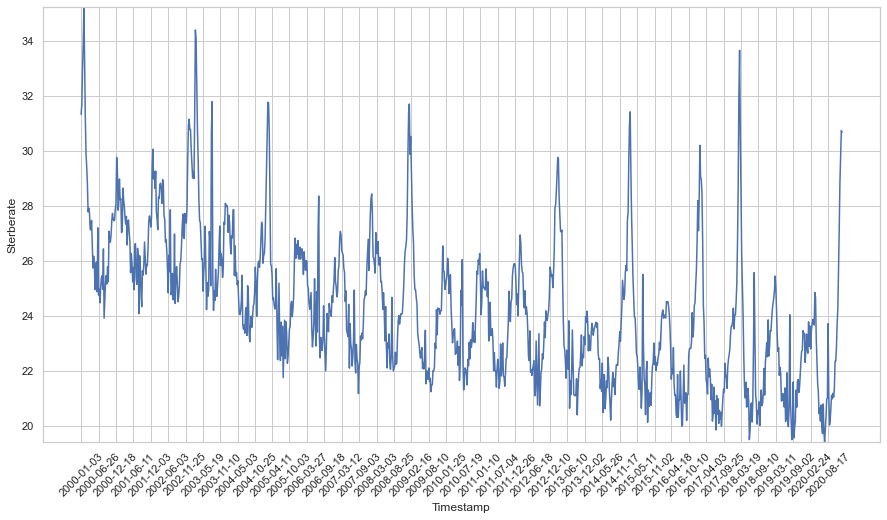

In [154]:
ax1 = sns.lineplot(x="Timestamp", y="Sterberate", data=sterberaten_bereinigt_woche)
plt.xticks(rotation=45)

f = plt.gca()



f.set_ylim([min(sterberaten_bereinigt_woche.Sterberate), max(sterberaten_bereinigt_woche.Sterberate)])
ax1.set(xticks=sterberaten_bereinigt_woche.Timestamp[::25])
plt.gcf().set_size_inches(15, 8)

In [138]:
xticks = [i for i in range(2000,2021)]


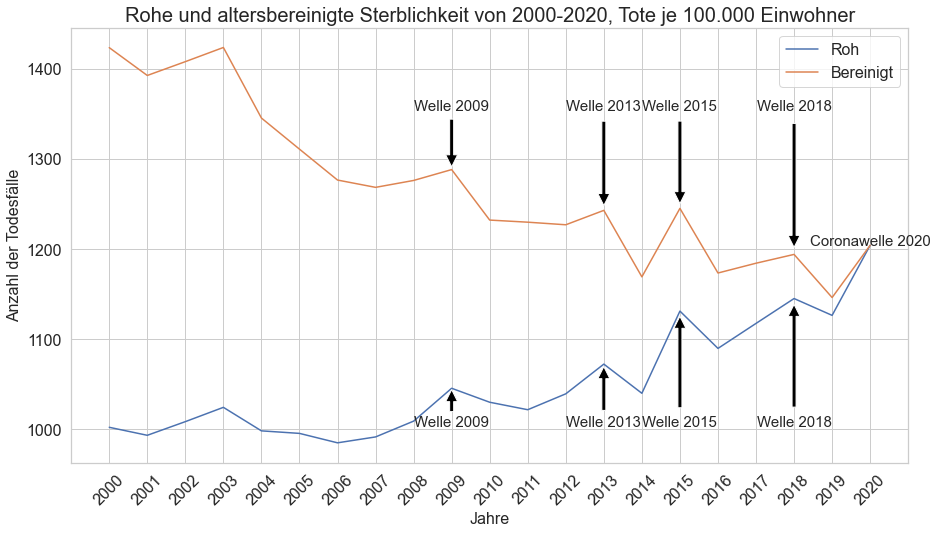

In [139]:

ax = sns.lineplot(x="Jahr",  y='Sterberate', data=sterberaten_roh)
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate', data=sterberaten_bereinigt)
plt.legend(labels=['Roh','Bereinigt'],fontsize= 16)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=45)


# annotate lines
grippe_wellen = [2009,2013,2015,2018,2020]

for weave in grippe_wellen:
    sel_year_raw = sterberaten_roh.loc[sterberaten_roh["Jahr"] == weave]
    raw_year = sel_year_raw.Jahr
    raw_death = sel_year_raw.Sterberate

    sel_year_cleaned = sterberaten_bereinigt.loc[sterberaten_bereinigt["Jahr"] == weave]
    cleaned_year = sel_year_cleaned.Jahr
    cleaned_death = sel_year_cleaned.Sterberate
    if  weave == 2020:
     ax.annotate("Coronawelle " + str(weave), xy=(raw_year, raw_death),xycoords='data', size = 15,ha='center')
    else:
        ax.annotate("Welle "+str(weave), xy=(raw_year, raw_death), xycoords='data',xytext=(raw_year, 1000), size = 15,ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')

        ax.annotate("Welle " +str(weave), xy=(cleaned_year, cleaned_death),xycoords='data',xytext=(cleaned_year, 1350),size = 15, ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')

ax.set_ylabel("Anzahl der Todesfälle", fontsize = 16)
ax.set_xlabel("Jahre", fontsize = 16)
ax.set_title("Rohe und altersbereinigte Sterblichkeit von 2000-2020, Tote je 100.000 Einwohner",fontsize = 20)
plt.xticks(range(min(xticks), max(xticks)+1, 1), fontsize=16)
plt.yticks(fontsize=16)
# plt.ylabel("Sterberate je 100.000 Einwohner")
# plt.xticks(df_grippe_w.index, df_grippe_w["Alter"], rotation=45)
# plt.axis([0, 14, 0, 5000])
plt.gcf().set_size_inches(15, 8)

## Anschließend wird die Sterblichkeit von 2000 bis 2020 dargestellt

In [140]:
#altersbereinigt
#loop über Wochen
for n in range(0,21):
    z = sterbefälle_woche.loc[(sterbefälle_woche["Jahr"]==2020-n)]
    q = new_df.loc[new_df["Jahr"]==2020-n]
    erg_sum = 0
    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[14]][2]

    #loop über wochen
    for j in range (1, 54):
        sum = 0
        #loop über Altersgruppen
        for i in range(0,14):

            asx = standard_bevölkerung.loc[standard_bevölkerung.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
            bevölkerung_grp = q.loc[q.index[i]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
            subx = ((z.loc[z.index[i+1]][j]) / bevölkerung_grp) * 100000 #sterberate je altersgruppe

            sum += (asx * subx)


        erg = sum / gesamt_bev
        erg_sum += erg

    #print(2020-n, "Altersbereinigt:",erg_sum)
    sterberaten_bereinigt.append([2020-n, erg_sum])

C:\Users\mikes\AppData\Local\Temp\ipykernel_169292\868277333.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sterberaten_bereinigt.append([2020-n, erg_sum])


In [141]:
sterbefälle_woche

,Nr.,Jahr,Alter,1,2,3,4,5,6,7,...,44,45,46,47,48,49,50,51,52,53
0,33,2020,Insgesamt,18883,19408,18953,18827,19774,19038,19648,...,18584,19007,19727,20182,21304,22604,24003,24724,25554,25497
1,34,2020,0-30,137,135,130,117,160,151,153,...,141,125,127,132,116,154,130,106,147,128
2,35,2020,30-35,74,56,62,47,41,51,41,...,44,46,39,56,44,53,44,57,51,49
3,36,2020,35-40,82,98,79,78,79,77,72,...,81,74,74,74,73,102,76,96,91,84
4,37,2020,40-45,119,111,102,111,117,115,128,...,92,107,100,128,96,119,129,119,123,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,252,2000,70-75,2037,2147,2144,2296,2218,2171,2152,...,1836,1870,1792,1911,1873,1857,1946,1960,2025,0
331,253,2000,75-80,2771,2742,2965,2975,3183,2841,2687,...,2412,2454,2370,2460,2342,2431,2491,2439,2545,0
332,254,2000,80-85,2209,2266,2409,2446,2575,2397,2331,...,2017,1996,2110,2072,2033,2027,2102,2170,2230,0
333,255,2000,85-90,3560,3506,3598,3723,3879,3779,3428,...,2715,2829,2874,2856,2900,2848,2786,2812,3072,0


In [142]:
sterberaten_bereinigt

,Jahr,Sterberate
0,2020,1204.261472
1,2019,1146.302226
2,2018,1194.144178
3,2017,1184.367099
4,2016,1173.511079
5,2015,1245.195949
6,2014,1169.234530
7,2013,1242.989400
8,2012,1227.009175
9,2011,1229.876761


In [143]:
# Grippe
grippe_wellen = [2009,2013,2015,2017,2018,2020]
mask = sterberaten_bereinigt.loc[sterberaten_bereinigt.Jahr.isin(grippe_wellen)].index
sterblichkeit_grippe = sterberaten_bereinigt.loc[mask,:]

In [144]:
sterblichkeit_grippe["Todesursache"] = ["Corona", "Grippe", "Grippe","Grippe", "Grippe", "Grippe"]
sterblichkeit_grippe


,Jahr,Sterberate,Todesursache
0,2020,1204.261472,Corona
2,2018,1194.144178,Grippe
3,2017,1184.367099,Grippe
5,2015,1245.195949,Grippe
7,2013,1242.989400,Grippe
11,2009,1288.212808,Grippe


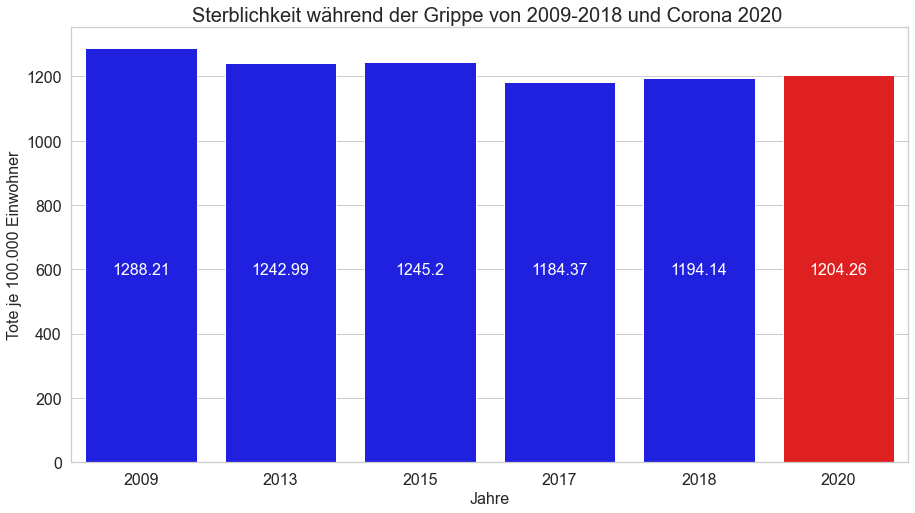

In [145]:
clrs = ['red' if x == 2020  else 'blue' for x in grippe_wellen]

bx = sns.barplot(data = sterblichkeit_grippe, x = "Jahr", y = "Sterberate", palette=clrs)
bx.set_title("Sterblichkeit während der Grippe von 2009-2018 und Corona 2020 ",fontsize = 20)
sns.set_theme(style="whitegrid")
bx.set_ylabel("Tote je 100.000 Einwohner", fontsize = 16)
bx.set_xlabel("Jahre", fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gcf().set_size_inches(15, 8)

for idx, weave in enumerate(grippe_wellen):
    sel_year_cleaned = sterblichkeit_grippe.loc[sterblichkeit_grippe["Jahr"] == weave]
    cleaned_year = sel_year_cleaned.Jahr.values[0]
    cleaned_death = sel_year_cleaned.Sterberate.values[0]
    if  weave == 2020:
        bx.text(x=idx , y =600, s = str(round(cleaned_death,2)), ha= "center", va = "center",fontsize= 16, color = "white")

    else:
        bx.text(x=idx, y =600, s =str(round(cleaned_death,2)), ha= "center", va = "center", fontsize= 16, color = "white" )


CMR

In [146]:
#altersbereinigt
#loop über jahre
cmr_sterberate = []
for n in range(0,21):
    z = sterbefälle_woche.loc[(sterbefälle_woche["Jahr"]==2020-n)]
    q = new_df.loc[new_df["Jahr"]==2020-n]
    erg_sum = 0
 
    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[14]][2]

    #loop über wochen
    for j in range (1, 54):
        sum = 0
  
        #loop über Altersgruppen
        for i in range(0,14):

            asx = standard_bevölkerung.loc[standard_bevölkerung.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
            bevölkerung_grp = q.loc[q.index[i]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
            subx = ((z.loc[z.index[i+1]][j]) / bevölkerung_grp) * 100000 #sterberate je altersgruppe
            
        

            sum += (asx * subx)   

           
            

        erg = sum / gesamt_bev
       
        erg_sum += erg
        

    #print(2020-n, "Altersbereinigt:",erg_sum)
    cmr_sterberate.append([2020-n, round(erg_sum,2), round(erg_sum/100000, 7)])

In [147]:
cmr_sterberate

[[2020, 1204.26, 0.0120426],
 [2019, 1146.3, 0.011463],
 [2018, 1194.14, 0.0119414],
 [2017, 1184.37, 0.0118437],
 [2016, 1173.51, 0.0117351],
 [2015, 1245.2, 0.012452],
 [2014, 1169.23, 0.0116923],
 [2013, 1242.99, 0.0124299],
 [2012, 1227.01, 0.0122701],
 [2011, 1229.88, 0.0122988],
 [2010, 1232.21, 0.0123221],
 [2009, 1288.21, 0.0128821],
 [2008, 1276.16, 0.0127616],
 [2007, 1268.5, 0.012685],
 [2006, 1276.61, 0.0127661],
 [2005, 1310.88, 0.0131088],
 [2004, 1345.38, 0.0134538],
 [2003, 1423.64, 0.0142364],
 [2002, 1407.92, 0.0140792],
 [2001, 1392.59, 0.0139259],
 [2000, 1423.45, 0.0142345]]

In [148]:
cmr_df = pd.DataFrame(cmr_sterberate, columns=["Jahr", "Sterberate je 100.000", "Sterberate"])
cmr_df["cmr"] = 0
for i in range (len(cmr_df)-1):

    cmr_df["cmr"][i] = cmr_df["Sterberate je 100.000"][i+1]/ cmr_df["Sterberate je 100.000"][i]

print(cmr_df)


    Jahr  Sterberate je 100.000  Sterberate       cmr
0   2020                1204.26    0.012043  0.951871
1   2019                1146.30    0.011463  1.041734
2   2018                1194.14    0.011941  0.991818
3   2017                1184.37    0.011844  0.990831
4   2016                1173.51    0.011735  1.061090
5   2015                1245.20    0.012452  0.938990
6   2014                1169.23    0.011692  1.063084
7   2013                1242.99    0.012430  0.987144
8   2012                1227.01    0.012270  1.002339
9   2011                1229.88    0.012299  1.001894
10  2010                1232.21    0.012322  1.045447
11  2009                1288.21    0.012882  0.990646
12  2008                1276.16    0.012762  0.993998
13  2007                1268.50    0.012685  1.006393
14  2006                1276.61    0.012766  1.026845
15  2005                1310.88    0.013109  1.026318
16  2004                1345.38    0.013454  1.058169
17  2003                1423

C:\Users\mikes\AppData\Local\Temp\ipykernel_169292\3758188338.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmr_df["cmr"][i] = cmr_df["Sterberate je 100.000"][i+1]/ cmr_df["Sterberate je 100.000"][i]


In [149]:
trend_over_last_four_years_cmr = np.sum(cmr_df["cmr"][0:4])/4

# line = {'Jahr' : 2021, 'Sterberate je 100.000': cmr_df["Sterberate je 100.000"][0] * trend_over_last_four_years_cmr, 'Sterberate' : cmr_df["Sterberate"][0]*trend_over_last_four_years_cmr, "cmr":trend_over_last_four_years_cmr}
cmr_df.loc[-1] = [2021, cmr_df["Sterberate je 100.000"][0] * trend_over_last_four_years_cmr, cmr_df["Sterberate"][0]*trend_over_last_four_years_cmr, trend_over_last_four_years_cmr]  # adding a row
cmr_df.index = cmr_df.index + 1  # shifting index
cmr_df.sort_index(inplace=True)


# cmr_df = cmr_df.append(line, ignore_index=True)
print(cmr_df)


      Jahr  Sterberate je 100.000  Sterberate       cmr
0   2021.0            1197.110935    0.011971  0.994064
1   2020.0            1204.260000    0.012043  0.951871
2   2019.0            1146.300000    0.011463  1.041734
3   2018.0            1194.140000    0.011941  0.991818
4   2017.0            1184.370000    0.011844  0.990831
5   2016.0            1173.510000    0.011735  1.061090
6   2015.0            1245.200000    0.012452  0.938990
7   2014.0            1169.230000    0.011692  1.063084
8   2013.0            1242.990000    0.012430  0.987144
9   2012.0            1227.010000    0.012270  1.002339
10  2011.0            1229.880000    0.012299  1.001894
11  2010.0            1232.210000    0.012322  1.045447
12  2009.0            1288.210000    0.012882  0.990646
13  2008.0            1276.160000    0.012762  0.993998
14  2007.0            1268.500000    0.012685  1.006393
15  2006.0            1276.610000    0.012766  1.026845
16  2005.0            1310.880000    0.013109  1